In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# Import the data

In [2]:
from utilities.proj1_helpers import *

In [3]:
train_data = load_csv_data("data/train.csv")
y_train, x_train, ids_train = train_data[0], train_data[1], train_data[2]
N, D = x_train.shape
print(y_train.shape, x_train.shape, ids_train.shape)

(250000,) (250000, 30) (250000,)


In [4]:
test_data = load_csv_data("data/test.csv")
y_test, x_test, ids_test = test_data[0], test_data[1], test_data[2]
print(y_test.shape, x_test.shape, ids_test.shape)

(568238,) (568238, 30) (568238,)


In [120]:
from utilities.implementations import *
from utilities.cross_validation import cross_validation, build_k_indices, split_data
#from utilities.pca import compute_pca
from utilities.preprocessing import standard_scaler

# Pre-process it

## Take care of missing values
Too many samples have at least one missing values (around 73%), we have to replace them with the mean (which will be 0 after normalization).

In [6]:
# Count the number of samples with missing values
count = 0
for i in range(len(x_train)):
    if -999.0 in x_train[i,:]:
        count += 1
        
print(count, "/", len(x_train), "=", count/len(x_train)*100, "% of samples with missing values")

181886 / 250000 = 72.7544 % of samples with missing values


In [7]:
def standardize_missing(x, x_missing_mask):
    """ Standardize the data and set the missing values to 0(=the mean) """
    # Normalize and center the data considering ONLY the correct values
    x_mean = np.zeros(x.shape[1])
    x_std  = np.zeros(x.shape[1])

    # Loop on the features, compute the mean/std without the missing values
    for i in range(x.shape[1]):
        feature_values = x[x_missing_mask[:, i], i]
        x_mean[i] = feature_values.mean()
        x_std[i]  = feature_values.std()
    
    # Normalize and center the data
    x_norm = (x - x_mean) / x_std
    # Set the missing values to 0 (= the mean)
    x_norm[np.invert(x_missing_mask)] = 0.
    return x_norm, x_mean, x_std

In [8]:
x, x_train_mean, x_train_std = standardize_missing(x_train, x_train!=-999.)
print(x.shape, x_train_mean.shape, x_train_std.shape)

(250000, 30) (30,) (30,)


## PCA
In order to reduce the dimensionality and decorrelate the data.

In [77]:
def compute_pca(x, number_pc=-1, variance=0.95):
    N, D = np.shape(x)

    # Center the data
    g = np.mean(x, axis=0) # center of mass
    x_c = x - g
    
    # Spectral analysis
    Sigma = x_c.T.dot(x_c)
    values, vectors = np.linalg.eig(Sigma)
    idx = values.argsort()[::-1] # eigenvalues and eigenvectors sorted together in decreasing order
    values = values[idx]
    vectors = vectors[:, idx]
    
    # Selecting the principal components
    if number_pc < 0:
        rank = np.sum(values)
        sum_values = values[0]
        number_pc = 1
        #print(sum_values/rank) #### PRINT HERE
        while sum_values/rank < variance:
            sum_values += values[number_pc]
            number_pc += 1
            #print(sum_values/rank) #### PRINT HERE
    pc = x_c.dot(vectors[:, :number_pc])
    return pc, vectors[:, :number_pc]

In [10]:
x_pc, eigenvectors = compute_pca(x, x.shape[1])
print(x_pc.shape, "\n", eigenvectors.shape)

(250000, 30) 
 (30, 30)


## Plot the data
Plot the data in 3D (along 3 arbitrary axis), blue is for the signal, and red for the background.

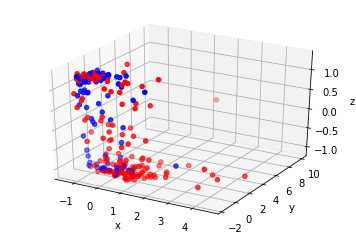

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Subsamples
x_sub = x[::1000] # x to have original data (normalized and centered), and x_pc to use the data after the PCA
y_sub = y_train[::1000]

y_color = ['blue' if y_sub[i] > 0. else 'red' for i in range(len(y_sub))]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(x_sub[:, 1], x_sub[:, 2], x_sub[:, 11], c=y_color) # change the numbers to have different plotting axis
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()

## Build polynomial features
Build polynomial features, and a column of 1s at the beginning.

In [12]:
def build_poly(x, d=1):
    """ Build polynomial features out of the given data, up to degree 'd' >= 1 """
    # At least degree 1
    if d < 1:
        d = 1
    
    tx = np.ones(x.shape[0])
    for i in range(d):
        tx = np.c_[tx, x**(i+1)]
    return tx

## Pre-processing function
Build polynomial features + standardize and take care of missing values

In [13]:
def preprocess_data(x_train, degree=1, missing_value=-999.):
    # Build polynomial features
    x = build_poly(x_train, degree)
    
    # Create a mask for the missing values (=False)
    x_train_mask = (x_train != -999.)
    x_mask = x_train_mask
    for i in range(degree-1):
        x_mask = np.c_[x_mask, x_train_mask]
    
    # Standardize the features, and set the missing values to 0(=the mean)
    tx, x_mean, x_std = standardize_missing(x[:,1:], x_mask)
    tx = np.c_[np.ones(x.shape[0]), tx]
    
    return tx, x_mean, x_std

# Learn a model

In [14]:
def accuracy(y, x, w):
    """ Compute the accuracy of the classification """
    y_pred = predict_labels(w, x)
    return 1. - np.sum(np.absolute(y - y_pred)) / 2. / y.shape[0]

## Split the data
Split the data into train and validation set. We first learn the model on the train set, and then test it on the validation set.

The ration gives the percent of the data going to train (ratio = 0.8 means 80% for training and 20% for validating).

In [305]:
seed = 3
degree = 11
ratio = 0.66

# Build poly + standardization
tx, x_mean, x_std = preprocess_data(np.delete(x_train, 22, axis=1), degree)
# Boolean features
tx = np.c_[tx, x_train[:,0] == -999, x_train[:,22] == 1, x_train[:,22] == 2 , x_train[:,22] == 3]
print(tx.shape, x_mean.shape, x_std.shape)

x_tr, y_tr, x_te, y_te = split_data(tx, y_train, ratio, seed)
print(x_tr.shape, x_te.shape, "\n", x_tr.shape[0] / (x_tr.shape[0]+x_te.shape[0])*100, "% of training")

(250000, 324) (319,) (319,)
(165000, 324) (85000, 324) 
 66.0 % of training


## Weight and loss
Compute here the weight and the resulting loss of the chosen model.

In [ ]:
## Logistic regression

# y = {-1; +1} => y = {0; +1}
y_tr_log = (y_tr + 1) / 2

initial_w = np.zeros(x_tr.shape[1])
max_iters = 10000
gamma     = 5E-6

w, loss_tr = logistic_regression(y_tr_log, x_tr, initial_w, max_iters, gamma)
print("Train logistic loss =", loss_tr)

# Compute the accuracy
accuracy_tr = accuracy(y_tr, x_tr, w)
print("Train Accuracy =", accuracy_tr)

In [306]:
# LS / ridge regression
lambda_ = 0.
w, loss_tr = least_squares(y_tr, x_tr)
print("Train MSE loss =", loss_tr)

# Compute the accuracy
accuracy_tr = accuracy(y_tr, x_tr, w)
print("Train Accuracy =", accuracy_tr)

Train MSE loss = 0.270127538035
Train Accuracy = 0.820218181818


## Test the model
Test the learned model on the validation set.

In [307]:
# y = {-1; +1} => y = {0; +1}
#y_te_log = (y_te + 1) / 2

#loss_te = compute_logistic_loss(y_te_log, x_te, w)
#print("Test logistic loss =", loss_te)

loss_te = compute_mse_loss(y_te, x_te, w)
print("Test MSE loss =", loss_te)

# Compute the accuracy
accuracy_te = accuracy(y_te, x_te, w)
print("Test Accuracy =", accuracy_te)

Test MSE loss = 482907.158566
Test Accuracy = 0.819835294118


In [304]:
train_acc = np.array([0.820466666667, 0.819648484848, 0.819533333333, 0.810090909091, 0.819775757576])
test_acc  = np.array([0.816317647059, 0.817788235294, 0.819435294118, 0.808529411765, 0.818611764706])

print("Train :", train_acc.mean(), "+-", train_acc.std())
print("Test :", test_acc.mean(), "+-", test_acc.std())

Train : 0.817903030303 +- 0.00391951722066
Test : 0.816136470588 +- 0.00394050283966


## Cross-validation
Do k-fold cross validation on a specific set of parameter.

(250000, 34) (29,) (29,)
(250000, 63) (58,) (58,)
(250000, 92) (87,) (87,)
(250000, 121) (116,) (116,)
(250000, 150) (145,) (145,)
(250000, 179) (174,) (174,)
(250000, 208) (203,) (203,)
(250000, 237) (232,) (232,)
(250000, 266) (261,) (261,)
(250000, 295) (290,) (290,)
(250000, 324) (319,) (319,)
(250000, 353) (348,) (348,)
(250000, 382) (377,) (377,)
(250000, 411) (406,) (406,)
(250000, 440) (435,) (435,)
(250000, 469) (464,) (464,)
(250000, 498) (493,) (493,)
(250000, 527) (522,) (522,)
(250000, 556) (551,) (551,)
(250000, 585) (580,) (580,)
(250000, 614) (609,) (609,)
(250000, 643) (638,) (638,)
(250000, 672) (667,) (667,)
(250000, 701) (696,) (696,)
(250000, 730) (725,) (725,)

Degree = 1 :
Train accuracy = 0.74692 +- 0.00041
Test accuracy  = 0.74692 +- 0.00204

Degree = 2 :
Train accuracy = 0.77483 +- 0.00063
Test accuracy  = 0.77485 +- 0.00162

Degree = 3 :
Train accuracy = 0.78650 +- 0.00060
Test accuracy  = 0.78618 +- 0.00124

Degree = 4 :
Train accuracy = 0.79487 +- 0.00092
T

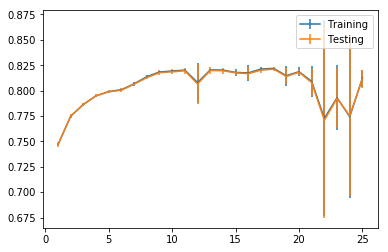

In [221]:
seed    = 3
degrees = [i for i in range(1, 26)]
k_fold  = 5
#gamma     = 1E-7
#lambda_   = 1E-2
#initial_w = np.zeros(x_tr.shape[1])
#max_iters = 1000

# Define arrays to store the accuracy of training data and test data
acc_tr = np.zeros((len(degrees), k_fold))
acc_te = np.zeros((len(degrees), k_fold))
for i,degree in enumerate(degrees):
    ## Pre-process the training data
    # Build poly + standardization
    tx, x_mean, x_std = preprocess_data(np.delete(x_train, 22, axis=1), degree)
    # Boolean features
    tx = np.c_[tx, x_train[:,0] == -999, x_train[:,22] == 1, x_train[:,22] == 2 , x_train[:,22] == 3]
    print(tx.shape, x_mean.shape, x_std.shape)

    # Split data in k fold
    k_indices = build_k_indices(y_train, k_fold, seed, stratification=True)

    for k in range(k_fold):
        # Get k'th subgroup in test, others in train
        x_tr = tx[k_indices[np.arange(len(k_indices))!=k].ravel(), :]
        y_tr = y_train[k_indices[np.arange(len(k_indices))!=k].ravel()]

        x_te = tx[k_indices[k], :]
        y_te = y_train[k_indices[k]]

        # Train the model
        w, loss_tr = least_squares(y_tr, x_tr)
        acc_tr[i, k] = accuracy(y_tr, x_tr, w)

        # Test the model    
        loss_te = compute_mse_loss(y_te, x_te, w)
        acc_te[i, k] = accuracy(y_te, x_te, w)

#print("{}\n{}".format(acc_tr, acc_te))
for i,degree in enumerate(degrees):
    print("\nDegree =", degree, ":")
    print("Train accuracy = {:.5f} +- {:.5f}".format(acc_tr[i, :].mean(), acc_tr[i, :].std()))
    print("Test accuracy  = {:.5f} +- {:.5f}".format(acc_te[i, :].mean(), acc_te[i, :].std()))

# Plot the results
plt.errorbar(np.array(degrees), acc_tr.mean(axis=1), acc_tr.std(axis=1))
plt.errorbar(np.array(degrees), acc_te.mean(axis=1), acc_te.std(axis=1))
plt.legend(["Training", "Testing"])
plt.show()

[autoreload of numpy failed: Traceback (most recent call last):
  File "C:\Users\nicol\Anaconda3\lib\site-packages\IPython\extensions\autoreload.py", line 246, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\nicol\Anaconda3\lib\site-packages\IPython\extensions\autoreload.py", line 369, in superreload
    module = reload(module)
  File "C:\Users\nicol\Anaconda3\lib\imp.py", line 314, in reload
    return importlib.reload(module)
  File "C:\Users\nicol\Anaconda3\lib\importlib\__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 608, in _exec
  File "<frozen importlib._bootstrap_external>", line 678, in exec_module
  File "<frozen importlib._bootstrap>", line 205, in _call_with_frames_removed
  File "C:\Users\nicol\Anaconda3\lib\site-packages\numpy\__init__.py", line 152, in <module>
    test = testing.nosetester._numpy_tester().test
NameError: name 'testing' is not defined
]
[autoreload of numpy.lib faile

[autoreload of numpy.polynomial.laguerre failed: Traceback (most recent call last):
  File "C:\Users\nicol\Anaconda3\lib\site-packages\IPython\extensions\autoreload.py", line 246, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\nicol\Anaconda3\lib\site-packages\IPython\extensions\autoreload.py", line 385, in superreload
    update_generic(old_obj, new_obj)
  File "C:\Users\nicol\Anaconda3\lib\site-packages\IPython\extensions\autoreload.py", line 324, in update_generic
    update(a, b)
  File "C:\Users\nicol\Anaconda3\lib\site-packages\IPython\extensions\autoreload.py", line 279, in update_class
    if old_obj == new_obj:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
]
[autoreload of numpy.ma.core failed: Traceback (most recent call last):
  File "C:\Users\nicol\Anaconda3\lib\site-packages\IPython\extensions\autoreload.py", line 246, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\nic

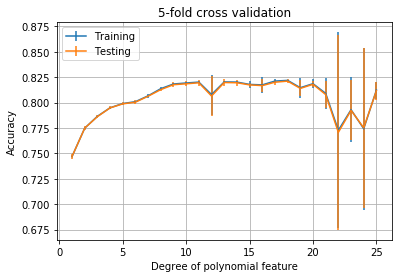

In [239]:
# Plot the results
plt.errorbar(np.array(degrees), acc_tr.mean(axis=1), acc_tr.std(axis=1))
plt.errorbar(np.array(degrees), acc_te.mean(axis=1), acc_te.std(axis=1))
plt.legend(["Training", "Testing"], loc=2)
plt.xlabel("Degree of polynomial feature")
plt.ylabel("Accuracy")
plt.title("{}-fold cross validation".format(k_fold))
plt.grid()

plt.savefig("figures/5fold_CV_seed3.pdf")

# Predict the Kaggle labels
Try to predicts the labels of the test set, then create a submission to be posted on Kaggle.

## Send the test set into the same space as the train set
In order to use the same weight, we need to send the testing data into the same space as the during the training (i.e. normalization, centering, PCA, etc.).

In [199]:
# Create a boolean mask with False at missing values
x_test_mask = (np.delete(x_test, 22, axis=1) != -999.0)

# Build polynomial features
x_kaggle = build_poly(np.delete(x_test, 22, axis=1), degree)
# Normalize and center the data (+ keep the "1's" column)
x_kaggle = np.c_[x_kaggle[:,0], (x_kaggle[:,1:] - x_mean) / x_std]

# Set to 0 (the mean) the missing values
x_kaggle_mask = np.c_[np.ones(x_kaggle.shape[0], dtype=bool), x_test_mask]
for i in range(degree-1):
    x_kaggle_mask = np.c_[x_kaggle_mask, x_test_mask]
x_kaggle[np.invert(x_kaggle_mask)] = 0.

# Boolean features
x_kaggle = np.c_[x_kaggle, x_test[:,0] == -999, x_test[:,22] == 1, x_test[:,22] == 2 , x_test[:,22] == 3]
print(x_kaggle.shape)

(568238, 411)


## Predict the labels, and create a submission

In [200]:
# Predict the labels
y_pred = predict_labels(w, x_kaggle)

# Create a sumbission file to be uploaded to the Kaggle competition
create_csv_submission(ids_test, y_pred, "nico_LS_poly14.csv")